In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import random
from sklearn.metrics import accuracy_score

import requests, zipfile, io
import os, glob
import shutil

print(tf.__version__)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

2.9.1
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070 SUPER, compute capability 7.5


In [2]:

data_dir = './data/poitry/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

url='https://storage.googleapis.com/tensorflow-1-public/course3/irish-lyrics-eof.txt'
with requests.get(url) as data:
    data.raise_for_status()
    
    with open(os.path.join(data_dir, 'irish-lyrics-eof.txt'), 'wt') as file:
        file.write(data.text)

            
print(os.listdir(data_dir))

['irish-lyrics-eof.txt']


In [3]:
vocab_size = 2500
max_length = 32
embedding_dim = 64
trunc_type='post'
padding_type='pre'
oov_tok = "<OOV>"
SHUFFLE_SIZE=64
BATCH_SIZE = 64
EPOCHS = 500
PATIENCE = 10
MONITOR = 'acc'

In [4]:
with open(os.path.join(data_dir, 'irish-lyrics-eof.txt')) as file:
    text = file.read().lower().split('\n')
    
print(text[:5])

['come all ye maidens young and fair', 'and you that are blooming in your prime', 'always beware and keep your garden fair', 'let no man steal away your thyme', 'for thyme it is a precious thing']


In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(text)   
print(tokenizer.word_index, '\n\n')


total_words = len(tokenizer.word_index) + 1 
print(total_words)

input_sequences = []
j = 0
for line in text:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

    if j == 0:
        print(line)
        print("convert the line of text into a list of the tokens representing the words: ", token_list)
        print("create a number of n-grams sequences: ", input_sequences)
    j=j+1

print(input_sequences[:50])

max_sequence_len = max([len(x) for x in input_sequences])
print("\n\nlength of the longest sentence in the corpus is: ", max_sequence_len)

In [6]:
input_sequences = np.array(tf.keras.preprocessing.sequence.pad_sequences(input_sequences, maxlen=max_sequence_len, padding=padding_type))
print("pad all of the sequences so that they are the same length:\n",  input_sequences, '\n', max([len(x) for x in input_sequences]))

# create predictors and label
xs, labels = input_sequences[:,:-1], input_sequences[:,-1]
print("xs:\n",xs[:][:3])
print(xs.shape)
print("labels:\n",labels[:][0:3])


ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)
print("convert the list to a categorical: put 1 in the index of the labels (encode the labels as it is a classification problem)\n",ys[0],"\n", ys[2])
print(ys.shape, '\n\n')


xtrain = tf.data.Dataset.from_tensor_slices(xs)
ytrain = tf.data.Dataset.from_tensor_slices(ys)
print(xtrain, ytrain)


train_dataset = tf.data.Dataset.zip((xtrain, ytrain)).shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
print(train_dataset)

pad all of the sequences so that they are the same length:
 [[   0    0    0 ...    0   51   12]
 [   0    0    0 ...   51   12   96]
 [   0    0    0 ...   12   96 1217]
 ...
 [   0    0    0 ...    0   47  105]
 [   0    0    0 ...   47  105  138]
 [   0    0    0 ...  105  138  184]] 
 16
xs:
 [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 51]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 51 12]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 51 12 96]]
(12038, 15)
labels:
 [  12   96 1217]
convert the list to a categorical: put 1 in the index of the labels (encode the labels as it is a classification problem)
 [0. 0. 0. ... 0. 0. 0.] 
 [0. 0. 0. ... 0. 0. 0.]
(12038, 2690) 


<TensorSliceDataset element_spec=TensorSpec(shape=(15,), dtype=tf.int32, name=None)> <TensorSliceDataset element_spec=TensorSpec(shape=(2690,), dtype=tf.float32, name=None)>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 15), dtype=tf.int32, name=None), TensorSpec(shape=(None, 2690), dtype=tf.float32, name=None))>


In [15]:
MODEL_NAME = './models/Generate_NLP_Poetry_LSTM_full_verse.h5'

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(total_words, embedding_dim, input_length=max_sequence_len-1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(48, activation='relu'),
    tf.keras.layers.Dense(total_words, activation='softmax')
])

# Setup the training parameters
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    # optimizer=tf.keras.optimizers.Nadam(1e-3),
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=['acc']
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 15, 64)            172160    
                                                                 
 bidirectional_14 (Bidirecti  (None, 15, 256)          197632    
 onal)                                                           
                                                                 
 bidirectional_15 (Bidirecti  (None, 15, 128)          164352    
 onal)                                                           
                                                                 
 bidirectional_16 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 48)                3120      
                                                      

Epoch 1/500
189/189 [==============================] - 9s 21ms/step - loss: 6.9252 - acc: 0.0556 - lr: 0.0010
Epoch 2/500
189/189 [==============================] - 4s 19ms/step - loss: 6.5127 - acc: 0.0657 - lr: 0.0010
Epoch 3/500
189/189 [==============================] - 3s 18ms/step - loss: 6.4802 - acc: 0.0657 - lr: 0.0010
Epoch 4/500
189/189 [==============================] - 3s 17ms/step - loss: 6.4673 - acc: 0.0657 - lr: 0.0010
Epoch 5/500
189/189 [==============================] - 3s 17ms/step - loss: 6.3912 - acc: 0.0657 - lr: 0.0010
Epoch 6/500
189/189 [==============================] - 4s 20ms/step - loss: 6.2773 - acc: 0.0664 - lr: 0.0010
Epoch 7/500
189/189 [==============================] - 4s 19ms/step - loss: 6.1657 - acc: 0.0678 - lr: 0.0010
Epoch 8/500
189/189 [==============================] - 3s 18ms/step - loss: 6.1191 - acc: 0.0679 - lr: 0.0010
Epoch 9/500
189/189 [==============================] - 4s 19ms/step - loss: 6.0458 - acc: 0.0680 - lr: 0.0010
Epoch 10/5

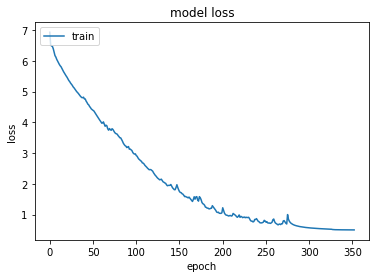

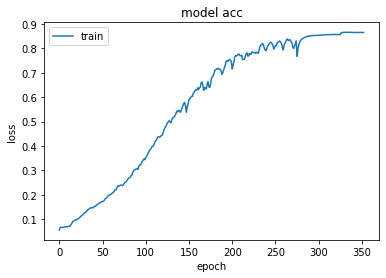

In [16]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor=MONITOR, factor=0.1, patience=PATIENCE, min_lr=1e-5)]
callbacks += [tf.keras.callbacks.ModelCheckpoint(MODEL_NAME, monitor=MONITOR, save_best_only=True)]
callbacks += [tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE*2, restore_best_weights=True)]

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    # validation_data=test_dataset,
    callbacks=callbacks
)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
seed_text = "Laurence went to dublin"
next_words = 100

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = tf.keras.preprocessing.sequence.pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    #predicted = model.predict_classes(token_list, verbose=0) # predict_classes used for classifiers (outputs are labels) and it returns the index of the class 
    #predict_classes were removed in TensorFlow version 2.6. so we can use this:
    predict_x=model.predict(token_list) 
    predicted=np.argmax(predict_x,axis=1)

    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

1/1 [==============================] - 0s 17ms/step
Laurence went to dublin o dancing darling sailing workin a leg for ballyjamesduff my vision o any young wheat sweet leane but free gray and you seen springing fresh and side and bade goodbye to love so hardship diddle jenny delight in day all the name of love said thems and whats there id hear to enjoy you get so snow easy to the morning early ive ever no and thinking in my heart calling only dropped bottles and leggins and a cool rose well parlay waves were still oh soon the little peek song with me neer shall oft and love grew with
